In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Full file analysis

In [2]:
# file_path = "C:\\Users\\kryst\\OneDrive\\Desktop\\airlines\\all_flights.csv"
flights = pd.read_csv("all_flights.csv")

In [3]:
flights.head()

,departureAirportID,departureAirportName,departureTime,arrivalAirportID,arrivalAirportName,arrivalAirportTime,airline,flightNumber,airplane,travelClass,...,price,tripType,totalTripDuration,carbonEmissionsThisFlight,carbonEmissionsTypicalRoute,carbonDifferencePercent,layovers,departureToken,metadataURL,metadataHTML
0,EWR,Newark Liberty International Airport,2025-05-08 17:00,MUC,Munich International Airport,2025-05-09 7:10,United,UA 30,Boeing 767,Economy,...,879,Round trip,610,524000,451000,16.0,Munich International Airport,W1t7ImRlcGFydHVyZUlkIjoiRVdSIiwiYXJyaXZhbElkIj...,https://www.google.com/travel/flights/search?h...,https://f005.backblazeb2.com/file/hasdata-scre...
1,MUC,Munich International Airport,2025-05-09 8:15,BSL,EuroAirport Basel-Mulhouse-Freiburg,2025-05-09 9:10,Lufthansa,LH 2394,Canadair RJ 900,Economy,...,879,Round trip,610,524000,451000,16.0,Munich International Airport,W1t7ImRlcGFydHVyZUlkIjoiRVdSIiwiYXJyaXZhbElkIj...,https://www.google.com/travel/flights/search?h...,https://f005.backblazeb2.com/file/hasdata-scre...
2,EWR,Newark Liberty International Airport,2025-05-08 18:00,FRA,Frankfurt Airport,2025-05-09 7:30,Lufthansa,LH 403,Boeing 747,Economy,...,882,Round trip,655,422000,451000,-6.0,Frankfurt Airport,W1t7ImRlcGFydHVyZUlkIjoiRVdSIiwiYXJyaXZhbElkIj...,https://www.google.com/travel/flights/search?h...,https://f005.backblazeb2.com/file/hasdata-scre...
3,FRA,Frankfurt Airport,2025-05-09 10:05,BSL,EuroAirport Basel-Mulhouse-Freiburg,2025-05-09 10:55,Lufthansa,LH 1202,Canadair RJ 900,Economy,...,882,Round trip,655,422000,451000,-6.0,Frankfurt Airport,W1t7ImRlcGFydHVyZUlkIjoiRVdSIiwiYXJyaXZhbElkIj...,https://www.google.com/travel/flights/search?h...,https://f005.backblazeb2.com/file/hasdata-scre...
4,EWR,Newark Liberty International Airport,2025-05-08 17:00,CDG,Paris Charles de Gaulle Airport,2025-05-09 6:10,Air France,AF 63,Airbus A350,Economy,...,1002,Round trip,850,433000,451000,-4.0,Paris Charles de Gaulle Airport,W1t7ImRlcGFydHVyZUlkIjoiRVdSIiwiYXJyaXZhbElkIj...,https://www.google.com/travel/flights/search?h...,https://f005.backblazeb2.com/file/hasdata-scre...


In [4]:
flights.shape

(14200, 23)

In [5]:
flights = flights.drop(["departureAirportName", "arrivalAirportName", "departureToken", "metadataURL", "metadataHTML"], axis=1)

# Convert departureTime and arrivalAirportTime from object to datetime
flights["fullDepartureTime"] = pd.to_datetime(flights["departureTime"])
flights["fullArrivalTime"] = pd.to_datetime(flights["arrivalAirportTime"])

# Drop the old arrivalAirportTime column (no longer needed)
flights = flights.drop(columns=["arrivalAirportTime"])

# Extract departure date and time
flights["departureDate"] = flights["fullDepartureTime"].dt.date
flights["departureTime"] = flights["fullDepartureTime"].dt.time

# Extract arrival date and time
flights["arrivalDate"] = flights["fullArrivalTime"].dt.date
flights["arrivalTime"] = flights["fullArrivalTime"].dt.time

# File split: direct and connecting flights

In [6]:
# Tag NYC and Swiss airports
nycAirports = ["JFK", "EWR", "LGA"]
swissAirports = ["ZRH", "GVA", "BSL"]

# Filter for direct flights
directFlights = flights[
    (flights["departureAirportID"].isin(nycAirports)) &
    (flights["arrivalAirportID"].isin(swissAirports))
].copy()

# Direct flights

In [7]:
directFlights = directFlights.drop("totalTripDuration", axis=1)
directFlights.shape

(687, 21)

In [8]:
# Compute adjusted duration in minutes (subtract 6 hours = 360 minutes)
directFlights["calculatedDuration"] = (directFlights["fullArrivalTime"] - directFlights["fullDepartureTime"]).dt.total_seconds() / 60 - 360

# Compare with existing durationTime column (assuming it's in minutes)
directFlights["durationMatches"] = (directFlights["durationTime"].round(1) == directFlights["calculatedDuration"].round(1))

In [9]:
directFlights.shape

(687, 23)

In [10]:
falseCount = (directFlights["durationMatches"] == False).sum()
print(f"Number of mismatches: {falseCount}")

Number of mismatches: 0


In [11]:
directFlights = directFlights.drop(["layovers", "calculatedDuration", "durationMatches"], axis=1)

for col in directFlights:
  print(col)

departureAirportID
departureTime
arrivalAirportID
airline
flightNumber
airplane
travelClass
legroom
extensions
durationTime
price
tripType
carbonEmissionsThisFlight
carbonEmissionsTypicalRoute
carbonDifferencePercent
fullDepartureTime
fullArrivalTime
departureDate
arrivalDate
arrivalTime


# Function building

In [12]:
def splitExtensions(df):
    # Ensure the column exists and fill NaNs with placeholders to avoid errors
    df["extensions"] = df["extensions"].fillna(",,")

    # Split into exactly 3 parts (strip whitespace too)
    splitExt = df["extensions"].str.split(",", n=2, expand=True).apply(lambda col: col.str.strip())

    # Rename columns appropriately
    df["recliningAndLegroom"] = splitExt[0]
    df["wifi"] = splitExt[1]
    df["carbonEmissionsEstimate"] = splitExt[2]

    return df

In [13]:
def uniqueValues(df):
    checkColumns = ["airline", "airplane", "legroom", "durationTime", "price",
                    "carbonEmissionsThisFlight", "carbonDifferencePercent",
                    "travelClass", "tripType",
                    "recliningAndLegroom", "wifi", "carbonEmissionsEstimate"]

    for col in checkColumns:
        if col in df.columns:
            print(f"\nUnique values for '{col}':")
            print(df[col].unique())
        else:
            print(f"\nColumn '{col}' not found in DataFrame.")

In [14]:
def classifyAirlines(df):
    # Define column-specific classification logic
    classificationRules = {
        "planeType": lambda x: "Airbus" if "Airbus" in str(x) else ("Boeing" if "Boeing" in str(x) else "Other"),
        "legroomClass": lambda x: "31 in" if "31" in str(x) else ("Unknown" if pd.isna(x) or "nan" in str(x).lower() else "Other"),
        "durationTimeClass": lambda x: str(int(x)) if not pd.isna(x) else "Unknown",
        "priceClass": lambda x: str(int(x)) if not pd.isna(x) else "Unknown",
        "carbonClass": lambda x: str(int(x)) if not pd.isna(x) else "Unknown",
        "carbonPercentClass": lambda x: str(int(x)) if not pd.isna(x) else "Unknown",
        "recliningAndLegroomClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
        "wifiClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
        "carbonEmissionsEstimateClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
        "travelClassClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
        "tripTypeClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
    }

    baseColumns = {
        "planeType": "airplane",
        "legroomClass": "legroom",
        "durationTimeClass": "durationTime",
        "priceClass": "price",
        "carbonClass": "carbonEmissionsThisFlight",
        "carbonPercentClass": "carbonDifferencePercent",
        "recliningAndLegroomClass": "recliningAndLegroom",
        "wifiClass": "wifi",
        "carbonEmissionsEstimateClass": "carbonEmissionsEstimate",
        "tripTypeClass": "tripType",
        "travelClassClass": "travelClass"
    }

    for new_col, source_col in baseColumns.items():
        if source_col not in df.columns:
            print(f"Skipping '{new_col}' — source column '{source_col}' not found.")
            continue

        # Apply classification
        df[new_col] = df[source_col].apply(classificationRules[new_col])

        # Group, count, and sort
        count_table = df.groupby(["airline", new_col]).size().unstack(fill_value=0)
        count_table["Total"] = count_table.sum(axis=1)
        count_table = count_table.sort_values("Total", ascending=False).drop(columns="Total")

        # Print result
        print(f"\n--- {new_col} grouped by airline ---")
        print(count_table)

In [15]:
def plotStackedBars(df, group_col, sub_col, title, legend_title, colors):
    """Helper function to group, sort, and plot stacked bar chart."""
    countDF = df.groupby([group_col, sub_col]).size().unstack(fill_value=0)
    countDF = countDF.loc[countDF.sum(axis=1).sort_values(ascending=False).index]

    plt.figure(figsize=(14, 6))
    countDF.plot(kind='bar', stacked=True, color=colors, edgecolor='none')

    plt.title(title)
    plt.ylabel("Number of Flights")
    plt.xlabel(group_col.capitalize())
    plt.xticks(rotation=0, ha='center')
    plt.legend(title=legend_title, loc="upper right")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

def runAirlineEDA(directFlights):
    """Runs EDA plots for airplane, legroom, and wifi counts by airline."""
    customColors = ['#d71920', '#00235f']

    # Clean data
    directFlights = directFlights.copy()
    directFlights["legroom"] = directFlights["legroom"].fillna("Extra reclining seat")
    if "recliningAndLegroom" in directFlights.columns:
        directFlights.drop(columns=["recliningAndLegroom"], inplace=True)

    # Airplane Types
    plotStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='airplane',
        title='Total Flights by Airline and Airplane Type',
        legend_title='Airplane Type',
        colors=customColors
    )

    # Legroom
    plotStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='legroom',
        title='Flight Legroom by Airline',
        legend_title='Legroom',
        colors=customColors
    )

    print("Note that the (4) seats with extra recline space are the only (4) seats in the dataset to fall under Premium Economy vs Economy seating.")

    # WiFi
    plotStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='wifi',
        title='Flight WiFi by Airline',
        legend_title='WiFi',
        colors=customColors
    )

In [16]:
def plotlyStackedBars(df, group_col, sub_col, title, legend_title, colors):
    """Helper function to group, sort, and plot stacked bar chart using Plotly."""
    countDF = df.groupby([group_col, sub_col]).size().unstack(fill_value=0)
    countDF = countDF.loc[countDF.sum(axis=1).sort_values(ascending=False).index]

    # Build bar chart
    fig = go.Figure()

    for i, sub_category in enumerate(countDF.columns):
        fig.add_trace(go.Bar(
            x=countDF.index,
            y=countDF[sub_category],
            name=sub_category,
            marker_color=colors[i % len(colors)],
        ))

    fig.update_layout(
        title=title,
        barmode='stack',
        xaxis_title=group_col.capitalize(),
        yaxis_title='Number of Flights',
        legend_title=legend_title,
        xaxis_tickangle=0,
        plot_bgcolor='white',
        bargap=0.2,
        font=dict(size=12)
    )

    fig.show()

def runAirlinePlotlyEDA(directFlights):
    """Runs EDA plots using Plotly for airplane, legroom, and wifi counts by airline."""
    customColors = ['#d71920', '#00235f', '#f9ba00', '#660000', '#000000', '#3366ff']

    # Copy and clean
    directFlights = directFlights.copy()
    directFlights["legroom"] = directFlights["legroom"].fillna("Extra reclining seat")
    if "recliningAndLegroom" in directFlights.columns:
        directFlights.drop(columns=["recliningAndLegroom"], inplace=True)

    # Airplane Types
    plotlyStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='airplane',
        title='Total Flights by Airline and Airplane Type',
        legend_title='Airplane Type',
        colors=customColors
    )

    # Legroom
    plotlyStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='legroom',
        title='Flight Legroom by Airline',
        legend_title='Legroom',
        colors=customColors
    )

    print("Note that the (4) seats with extra recline space are the only (4) seats in the dataset to fall under Premium Economy vs Economy seating.")

    # WiFi
    plotlyStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='wifi',
        title='Flight WiFi by Airline',
        legend_title='WiFi',
        colors=customColors
    )

In [17]:
def plotBubbleChart(df, airline_col, metric_col, yaxis_title, chart_title,
                    width=800, height=500):

    # Count grouped occurrences
    countDF = df.groupby([airline_col, metric_col]).size().reset_index(name='count')
    countDF = countDF.sort_values('count', ascending=False)

    # Custom airline ordering
    priorityOrder = ['SWISS', 'United', 'Delta']
    allAirlines = countDF[airline_col].unique()
    remainingAirlines = sorted([a for a in allAirlines if a not in priorityOrder])
    fullOrder = priorityOrder + remainingAirlines

    # Ensure airline column is categorical with the custom order
    countDF[airline_col] = pd.Categorical(countDF[airline_col], categories=fullOrder, ordered=True)
    countDF = countDF.sort_values(airline_col)

    # Create figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=countDF[airline_col],
        y=countDF[metric_col],
        mode='markers+text' if metric_col == 'durationTime' else 'markers',
        text=countDF['count'],
        marker=dict(
            size=countDF['count'],
            color=countDF[metric_col],
            colorscale='RdBu',
            showscale=True,
            sizemode='area',
            sizeref=2. * countDF['count'].max() / (100 ** 2),
            sizemin=4
        )
    ))

    fig.update_layout(
        title=dict(text=chart_title, x=0.5, xanchor='center'),
        xaxis_title='Airline',
        yaxis_title=yaxis_title,
        xaxis_tickangle=0,
        template='plotly_white',
        showlegend=False,
        width=width,
        height=height
    )

    fig.show()

In [18]:
def plotHeatmap(df, valueCol, title, xaxisTitle, colorscale='Blues', width=800, height=500):
    # Create pivot table
    pivot = df.groupby(['airline', valueCol]).size().unstack(fill_value=0)

    # Sort airlines by total volume
    pivot['Total'] = pivot.sum(axis=1)
    pivot = pivot.sort_values("Total", ascending=False).drop(columns="Total")

    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=pivot.values,
        x=pivot.columns.astype(str),
        y=pivot.index,
        colorscale=colorscale,
        colorbar=dict(title='Number of Flights')
    ))

    # Layout
    fig.update_layout(
        title=dict(text=title, x=0.5, xanchor='center'),
        xaxis_title=xaxisTitle,
        yaxis_title='Airline',
        template='plotly_white',
        width=width,
        height=height
    )

    fig.show()

# Function Execution

**Direct flight functions**

In [19]:
splitExtensions(directFlights)

,departureAirportID,departureTime,arrivalAirportID,airline,flightNumber,airplane,travelClass,legroom,extensions,durationTime,...,carbonEmissionsTypicalRoute,carbonDifferencePercent,fullDepartureTime,fullArrivalTime,departureDate,arrivalDate,arrivalTime,recliningAndLegroom,wifi,carbonEmissionsEstimate
22,EWR,17:25:00,GVA,United,UA 956,Boeing 767,Premium Economy,NaN,"Extra reclining seat, Wi‑Fi for a fee, Carbon ...",485,...,451000,90.0,2025-05-08 17:25:00,2025-05-09 07:30:00,2025-05-08,2025-05-09,07:30:00,Extra reclining seat,Wi‑Fi for a fee,Carbon emissions estimate: 710 kg
33,EWR,17:25:00,GVA,United,UA 956,Boeing 767,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",485,...,467000,1.0,2025-05-08 17:25:00,2025-05-09 07:30:00,2025-05-08,2025-05-09,07:30:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 473 kg
38,EWR,21:50:00,ZRH,SWISS,LX 19,Airbus A330,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",465,...,467000,-22.0,2025-05-08 21:50:00,2025-05-09 11:35:00,2025-05-08,2025-05-09,11:35:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 321 kg
40,EWR,18:05:00,ZRH,United,UA 134,Boeing 767,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",490,...,467000,-6.0,2025-05-08 18:05:00,2025-05-09 08:15:00,2025-05-08,2025-05-09,08:15:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 396 kg
44,EWR,18:05:00,ZRH,United,UA 134,Boeing 767,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",490,...,451000,-12.0,2025-05-08 18:05:00,2025-05-09 08:15:00,2025-05-08,2025-05-09,08:15:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 396 kg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14085,JFK,19:25:00,GVA,SWISS,LX 23,Airbus A330,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",470,...,467000,-26.0,2025-07-15 19:25:00,2025-07-16 09:15:00,2025-07-15,2025-07-16,09:15:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 344 kg
14086,JFK,20:50:00,GVA,Delta,DL 100,Boeing 767,Economy,31 in,"Average legroom (31 in), Free Wi‑Fi, Carbon em...",475,...,467000,-30.0,2025-07-15 20:50:00,2025-07-16 10:45:00,2025-07-15,2025-07-16,10:45:00,Average legroom (31 in),Free Wi‑Fi,Carbon emissions estimate: 327 kg
14087,JFK,16:15:00,ZRH,SWISS,LX 17,Airbus A330,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",475,...,451000,-36.0,2025-07-15 16:15:00,2025-07-16 06:10:00,2025-07-15,2025-07-16,06:10:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 288 kg
14088,JFK,20:30:00,ZRH,SWISS,LX 15,Airbus A330,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",475,...,451000,-36.0,2025-07-15 20:30:00,2025-07-16 10:25:00,2025-07-15,2025-07-16,10:25:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 288 kg


In [20]:
uniqueValues(directFlights)


Unique values for 'airline':
['United' 'SWISS' 'Delta']

Unique values for 'airplane':
['Boeing 767' 'Airbus A330']

Unique values for 'legroom':
[nan '31 in']

Unique values for 'durationTime':
[485 465 490 470 475 480]

Unique values for 'price':
[1482 1312 1331 1993  876 1764 1924 1003 1336  854 1747 1874  826  957
 1362  879 1796 1904  981 1345  829 1854  925 1405 1726  956  980  847
 1805 1914  946  655  674  707  815 1619  694  834  729  695  715  719
  767  848  969 1220  789  809  746 1308  917 1951 1964  932 1943 2123
  857 1893  896 1140 1930 1077 1086 1929 1167 1112 1039  739  865  774
 1104 1230  761  911 1059  931 1392  819  839  899  840  860  864  916
  937  800  877  850  927 1692 1908 2554 2954 2389 2432 1373 1512 2737
 2834 2312 1423 1426 1565 2158 2338 1072 2101 2169 1122  790  867  977
 1466 1082 2111 2179 1132 1412 1012 2059 2109 1062 2355 1147 2119 1096
 1137 2129 1141 1671 1443 2403 2583 1175 2364 1492 1245 2407 2434  934
  953 1037 1061 1125  973 1004 1117  984

In [21]:
classifyAirlines(directFlights)


--- planeType grouped by airline ---
planeType  Airbus  Boeing
airline                  
SWISS         372       0
United          0     180
Delta           0     135

--- legroomClass grouped by airline ---
legroomClass  31 in  Unknown
airline                     
SWISS           372        0
United          176        4
Delta           135        0

--- durationTimeClass grouped by airline ---
durationTimeClass  465  470  475  480  485  490
airline                                        
SWISS              117   74  181    0    0    0
United               0    0    0   56  101   23
Delta                0    0   54    0   27   54

--- priceClass grouped by airline ---
priceClass  1003  1004  1012  1037  1039  1048  1054  1059  1061  1062  ...  \
airline                                                                 ...   
SWISS          2     0    23    11     1     0     0     3     0     0  ...   
United         0     0     7     2     0     1     0     3     2     0  ...   
Delta

<Figure size 1400x600 with 0 Axes>

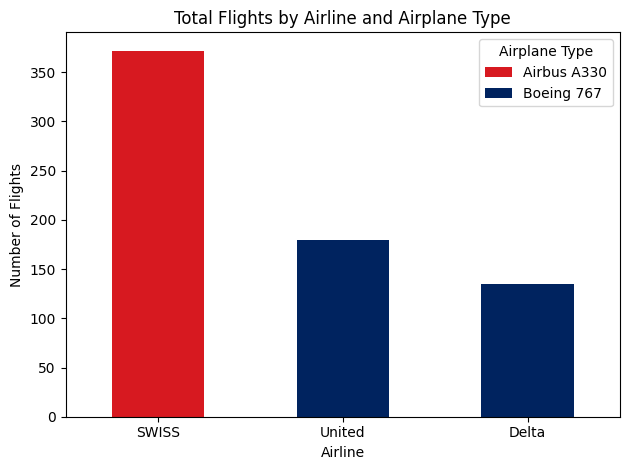

<Figure size 1400x600 with 0 Axes>

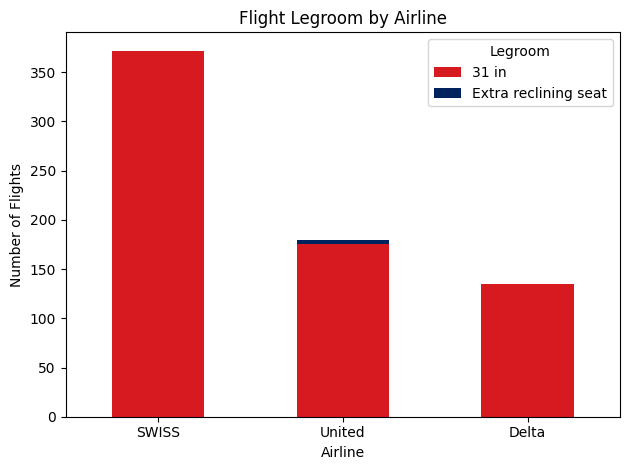

Note that the (4) seats with extra recline space are the only (4) seats in the dataset to fall under Premium Economy vs Economy seating.


<Figure size 1400x600 with 0 Axes>

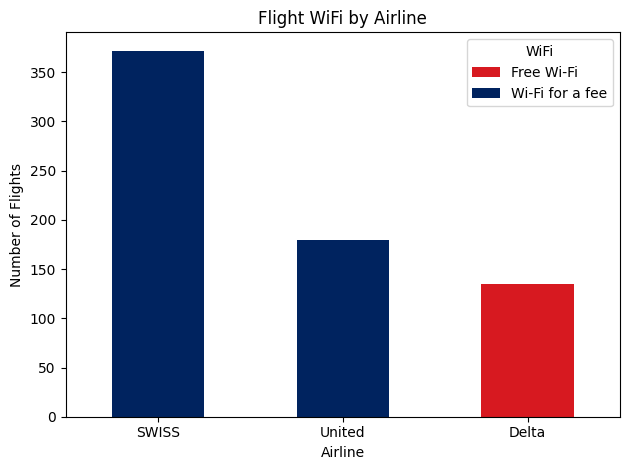

In [22]:
runAirlineEDA(directFlights)

In [23]:
runAirlinePlotlyEDA(directFlights)

Note that the (4) seats with extra recline space are the only (4) seats in the dataset to fall under Premium Economy vs Economy seating.


In [24]:
# Duration Time
plotBubbleChart(
    df=directFlights,
    airline_col='airline',
    metric_col='durationTime',
    yaxis_title='Duration (min)',
    chart_title='Flight Duration vs Airline (Bubble Size = Count)',
    width=1000
)

# Price
plotBubbleChart(
    df=directFlights,
    airline_col='airline',
    metric_col='price',
    yaxis_title='Price (USD)',
    chart_title='Flight Prices vs Airline (Bubble Size = Count)'
)

# Carbon Emissions
plotBubbleChart(
    df=directFlights,
    airline_col='airline',
    metric_col='carbonEmissionsThisFlight',
    yaxis_title='Carbon Emissions This Flight',
    chart_title='Flight Carbon Emissions vs Airline (Bubble Size = Count)'
)

# Carbon Difference Percent
plotBubbleChart(
    df=directFlights,
    airline_col='airline',
    metric_col='carbonDifferencePercent',
    yaxis_title='Carbon Difference Percent This Flight',
    chart_title='Carbon Percent Difference (to the Average) vs Airline (Bubble Size = Count)'
)

In [25]:
plotHeatmap(directFlights, 'carbonDifferencePercent', 'Carbon Difference Percent by Airline', 'Carbon Difference Percent', colorscale='Reds')
plotHeatmap(directFlights, 'price', 'Price by Airline', 'Price (USD)', colorscale='Reds')
plotHeatmap(directFlights, 'durationTime', 'Duration Time by Airline', 'Duration (min)', colorscale='Reds')

# Connecting flights

In [26]:
# Define direct flights condition
directFlights = (flights["departureAirportID"].isin(nycAirports)) & (flights["arrivalAirportID"].isin(swissAirports))

# Create connectingFlights as the inverse of directFlights
connectingFlights = flights[~directFlights].copy()

In [27]:
connectingFlights.shape

(13513, 22)

In [28]:
connectingFlights.head()

,departureAirportID,departureTime,arrivalAirportID,airline,flightNumber,airplane,travelClass,legroom,extensions,durationTime,...,totalTripDuration,carbonEmissionsThisFlight,carbonEmissionsTypicalRoute,carbonDifferencePercent,layovers,fullDepartureTime,fullArrivalTime,departureDate,arrivalDate,arrivalTime
0,EWR,17:00:00,MUC,United,UA 30,Boeing 767,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",490,...,610,524000,451000,16.0,Munich International Airport,2025-05-08 17:00:00,2025-05-09 07:10:00,2025-05-08,2025-05-09,07:10:00
1,MUC,08:15:00,BSL,Lufthansa,LH 2394,Canadair RJ 900,Economy,31 in,"Average legroom (31 in), Carbon emissions esti...",55,...,610,524000,451000,16.0,Munich International Airport,2025-05-09 08:15:00,2025-05-09 09:10:00,2025-05-09,2025-05-09,09:10:00
2,EWR,18:00:00,FRA,Lufthansa,LH 403,Boeing 747,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",450,...,655,422000,451000,-6.0,Frankfurt Airport,2025-05-08 18:00:00,2025-05-09 07:30:00,2025-05-08,2025-05-09,07:30:00
3,FRA,10:05:00,BSL,Lufthansa,LH 1202,Canadair RJ 900,Economy,31 in,"Average legroom (31 in), Carbon emissions esti...",50,...,655,422000,451000,-6.0,Frankfurt Airport,2025-05-09 10:05:00,2025-05-09 10:55:00,2025-05-09,2025-05-09,10:55:00
4,EWR,17:00:00,CDG,Air France,AF 63,Airbus A350,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",430,...,850,433000,451000,-4.0,Paris Charles de Gaulle Airport,2025-05-08 17:00:00,2025-05-09 06:10:00,2025-05-08,2025-05-09,06:10:00


**Connecting flight functions**

In [29]:
splitExtensions(connectingFlights)

,departureAirportID,departureTime,arrivalAirportID,airline,flightNumber,airplane,travelClass,legroom,extensions,durationTime,...,carbonDifferencePercent,layovers,fullDepartureTime,fullArrivalTime,departureDate,arrivalDate,arrivalTime,recliningAndLegroom,wifi,carbonEmissionsEstimate
0,EWR,17:00:00,MUC,United,UA 30,Boeing 767,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",490,...,16.0,Munich International Airport,2025-05-08 17:00:00,2025-05-09 07:10:00,2025-05-08,2025-05-09,07:10:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 457 kg
1,MUC,08:15:00,BSL,Lufthansa,LH 2394,Canadair RJ 900,Economy,31 in,"Average legroom (31 in), Carbon emissions esti...",55,...,16.0,Munich International Airport,2025-05-09 08:15:00,2025-05-09 09:10:00,2025-05-09,2025-05-09,09:10:00,Average legroom (31 in),Carbon emissions estimate: 67 kg,None
2,EWR,18:00:00,FRA,Lufthansa,LH 403,Boeing 747,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",450,...,-6.0,Frankfurt Airport,2025-05-08 18:00:00,2025-05-09 07:30:00,2025-05-08,2025-05-09,07:30:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 361 kg
3,FRA,10:05:00,BSL,Lufthansa,LH 1202,Canadair RJ 900,Economy,31 in,"Average legroom (31 in), Carbon emissions esti...",50,...,-6.0,Frankfurt Airport,2025-05-09 10:05:00,2025-05-09 10:55:00,2025-05-09,2025-05-09,10:55:00,Average legroom (31 in),Carbon emissions estimate: 61 kg,None
4,EWR,17:00:00,CDG,Air France,AF 63,Airbus A350,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",430,...,-4.0,Paris Charles de Gaulle Airport,2025-05-08 17:00:00,2025-05-09 06:10:00,2025-05-08,2025-05-09,06:10:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 351 kg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14195,BOS,17:05:00,FCO,ITA,AZ 615,Airbus A330,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",480,...,29.0,"Boston Logan International Airport, Leonardo d...",2025-07-15 17:05:00,2025-07-16 07:05:00,2025-07-15,2025-07-16,07:05:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 419 kg
14196,FCO,16:40:00,ZRH,ITA,AZ 574,Airbus A220-300 Passenger,Economy,30 in,"Average legroom (30 in), Wi‑Fi for a fee, Carb...",95,...,29.0,"Boston Logan International Airport, Leonardo d...",2025-07-16 16:40:00,2025-07-16 18:15:00,2025-07-16,2025-07-16,18:15:00,Average legroom (30 in),Wi‑Fi for a fee,Carbon emissions estimate: 83 kg
14197,LGA,13:59:00,BOS,Delta,DL 5739,Embraer 175,Economy,31 in,"Average legroom (31 in), Wi‑Fi for a fee, Carb...",75,...,9.0,"Boston Logan International Airport, Amsterdam ...",2025-07-15 13:59:00,2025-07-15 15:14:00,2025-07-15,2025-07-15,15:14:00,Average legroom (31 in),Wi‑Fi for a fee,Carbon emissions estimate: 79 kg
14198,BOS,16:45:00,AMS,Delta,DL 256,Airbus A330-900neo,Economy,31 in,"Average legroom (31 in), Free Wi‑Fi, Carbon em...",415,...,9.0,"Boston Logan International Airport, Amsterdam ...",2025-07-15 16:45:00,2025-07-16 05:40:00,2025-07-15,2025-07-16,05:40:00,Average legroom (31 in),Free Wi‑Fi,Carbon emissions estimate: 355 kg


In [37]:
def classifyAirlines(df):
    def classifyPlane(plane):
        plane = str(plane)
        if "Airbus" in plane:
            return "Airbus"
        elif "Boeing" in plane:
            return "Boeing"
        elif "Embraer" in plane:
            return "Embraer"
        elif "Canadair" in plane or "Dash" in plane:
            return "Canadair"
        elif plane.lower() == "nan":
            return "Unknown"
        else:
            return "Other"

    def classifyLegroom(legroom):
        if pd.isna(legroom):
            return "Unknown"
        try:
            value = int(str(legroom).split()[0])
            if value == 28:
                return "28 in"
            elif value == 29:
                return "29 in"
            elif value == 30:
                return "30 in"
            elif value == 31:
                return "31 in"
            elif value == 32:
                return "32"
            elif value == 33:
                return "33 in"
        except:
            return "Unknown"

    classificationRules = {
        "planeType": classifyPlane,
        "legroomClass": classifyLegroom,
        "durationTimeClass": lambda x: str(int(x)) if not pd.isna(x) else "Unknown",
        "priceClass": lambda x: str(int(x)) if not pd.isna(x) else "Unknown",
        "carbonClass": lambda x: str(int(x)) if not pd.isna(x) else "Unknown",
        "carbonPercentClass": lambda x: str(int(x)) if not pd.isna(x) else "Unknown",
        "recliningAndLegroomClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
        "wifiClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
        "carbonEmissionsEstimateClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
        "travelClassClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
        "tripTypeClass": lambda x: x.strip() if isinstance(x, str) and x.strip() else "Unknown",
    }

    baseColumns = {
        "planeType": "airplane",
        "legroomClass": "legroom",
        "durationTimeClass": "durationTime",
        "priceClass": "price",
        "carbonClass": "carbonEmissionsThisFlight",
        "carbonPercentClass": "carbonDifferencePercent",
        "recliningAndLegroomClass": "recliningAndLegroom",
        "wifiClass": "wifi",
        "carbonEmissionsEstimateClass": "carbonEmissionsEstimate",
        "tripTypeClass": "tripType",
        "travelClassClass": "travelClass"
    }

    for new_col, source_col in baseColumns.items():
        if source_col not in df.columns:
            print(f"Skipping '{new_col}' — source column '{source_col}' not found.")
            continue

        df[new_col] = df[source_col].apply(classificationRules[new_col])

        count_table = df.groupby(["airline", new_col]).size().unstack(fill_value=0)
        count_table["Total"] = count_table.sum(axis=1)
        count_table = count_table.sort_values("Total", ascending=False).drop(columns="Total")

        print(f"\n--- {new_col} grouped by airline ---")
        print(count_table)

In [30]:
uniqueValues(connectingFlights)


Unique values for 'airline':
['United' 'Lufthansa' 'Air France' 'British Airways' 'Air Dolomiti'
 'Delta' 'Turkish Airlines' 'Air Canada' 'SWISS' 'Scandinavian Airlines'
 'LOT' 'Tap Air Portugal' 'Austrian' 'Norse Atlantic UK' 'easyJet'
 'Norse Atlantic Airways' 'KLM' 'American' 'ITA' 'Condor' 'JetBlue'
 'Aer Lingus' 'Iberia' 'Icelandair' 'French bee' 'Air Europa'
 'Brussels Airlines' 'Aegean' 'Eurowings' 'Finnair' 'Vueling'
 'Royal Air Maroc' 'Norwegian' 'Edelweiss Air']

Unique values for 'airplane':
['Boeing 767' 'Canadair RJ 900' 'Boeing 747' 'Airbus A350' 'Embraer 170'
 'Boeing 777' 'Airbus A320' 'Embraer 190' 'Embraer 175'
 'Airbus A330-900neo' 'Airbus A321 (Sharklets)'
 'Airbus A220-300 Passenger' 'Airbus A330' 'Airbus A220-100 Passenger'
 'Airbus A321neo' 'Airbus A320neo' 'Airbus A319' 'Boeing 787'
 'Embraer 195' 'Boeing 737MAX 8 Passenger' 'Airbus A321' nan
 'Boeing 787-10' 'Canadair RJ 1000' 'Airbus A340' 'Boeing 737'
 'Airbus A380' 'Embraer 195 E2' 'Airbus A318' 'Embraer 19

In [38]:
classifyAirlines(connectingFlights)


--- planeType grouped by airline ---
planeType               Airbus  Boeing  Canadair  Embraer  Unknown
airline                                                           
Lufthansa                  426     382       754        0        0
British Airways            953     513         0        0        0
United                      31     868         0      385        0
Air Canada                 576     232       263      126        0
Delta                      438      90        16      460        0
American                   154     360        13      469        0
KLM                         26     379         0      463        0
Air France                 363     203         0      286        0
Scandinavian Airlines      510       2       116       90        0
SWISS                      659      28         0       26        0
Tap Air Portugal           334       0         0        7        1
Air Dolomiti                 0       0         0      317        0
easyJet                 

In [40]:
def plotStackedBars(df, group_col, sub_col, title, legend_title, colors, top_n=10):
    """Group, sort, and plot stacked bar chart for top N groups by total size."""
    countDF = df.groupby([group_col, sub_col]).size().unstack(fill_value=0)

    # Compute totals and get top N group names
    top_groups = countDF.sum(axis=1).sort_values(ascending=False).head(top_n).index

    # Filter and re-sort
    countDF = countDF.loc[top_groups]
    countDF = countDF.loc[countDF.sum(axis=1).sort_values(ascending=False).index]

    plt.figure(figsize=(14, 6))
    countDF.plot(kind='bar', stacked=True, color=colors, edgecolor='none')

    plt.title(title)
    plt.ylabel("Number of Flights")
    plt.xlabel(group_col.capitalize())
    plt.xticks(rotation=0, ha='center')
    plt.legend(title=legend_title, loc="upper right")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

def runAirlineEDA(directFlights):
    """Runs EDA plots for airplane, legroom, and wifi counts by airline (top 10 only)."""
    customColors = ['#d71920', '#00235f']

    # Clean data
    directFlights = directFlights.copy()
    directFlights["legroom"] = directFlights["legroom"].fillna("Extra reclining seat")
    if "recliningAndLegroom" in directFlights.columns:
        directFlights.drop(columns=["recliningAndLegroom"], inplace=True)

    # Airplane Types
    plotStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='airplane',
        title='Total Flights by Airline and Airplane Type',
        legend_title='Airplane Type',
        colors=customColors
    )

    # Legroom
    plotStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='legroom',
        title='Flight Legroom by Airline',
        legend_title='Legroom',
        colors=customColors
    )

    print("Note that the (4) seats with extra recline space are the only (4) seats in the dataset to fall under Premium Economy vs Economy seating.")

    # WiFi
    plotStackedBars(
        df=directFlights,
        group_col='airline',
        sub_col='wifi',
        title='Flight WiFi by Airline',
        legend_title='WiFi',
        colors=customColors
    )


<Figure size 1400x600 with 0 Axes>

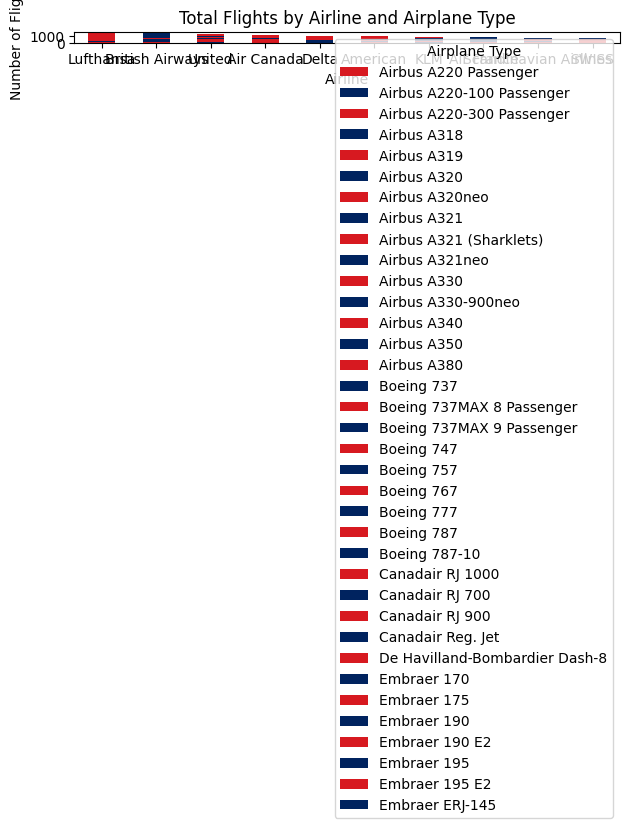

<Figure size 1400x600 with 0 Axes>

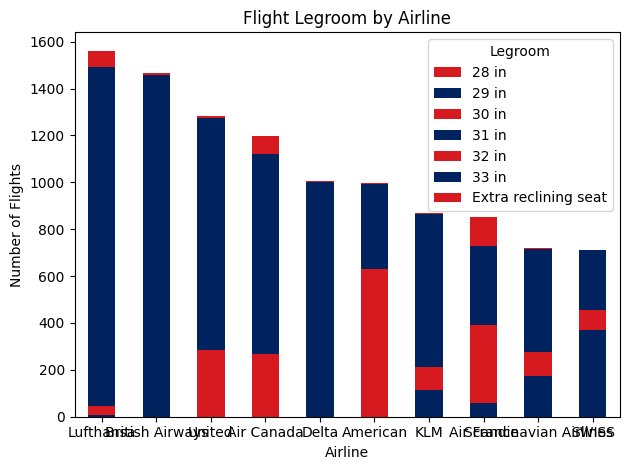

Note that the (4) seats with extra recline space are the only (4) seats in the dataset to fall under Premium Economy vs Economy seating.


<ipython-input-40-81f502a9a7c7>:22: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



<Figure size 1400x600 with 0 Axes>

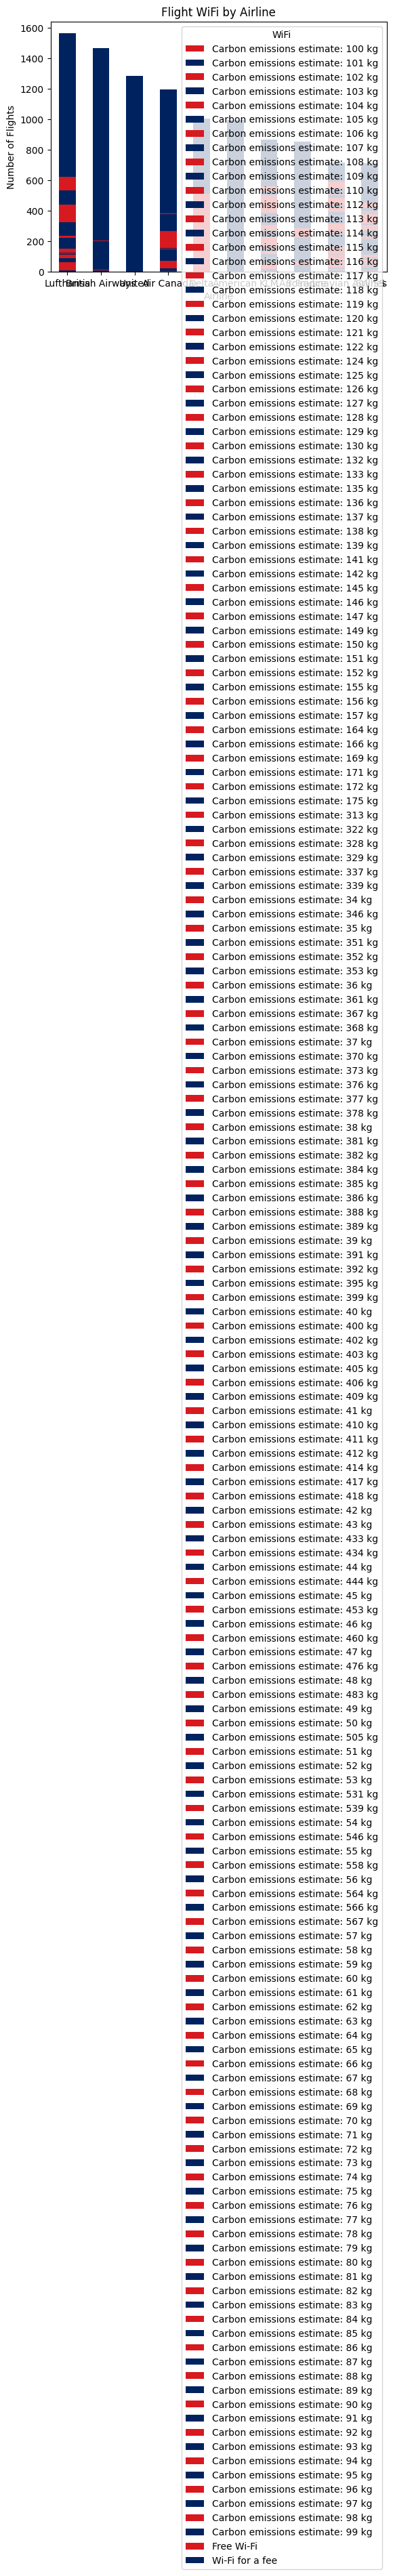

In [41]:
runAirlineEDA(connectingFlights)

In [43]:
runAirlinePlotlyEDA(connectingFlights)

Note that the (4) seats with extra recline space are the only (4) seats in the dataset to fall under Premium Economy vs Economy seating.


In [42]:
# Duration Time
plotBubbleChart(
    df=connectingFlights,
    airline_col='airline',
    metric_col='durationTime',
    yaxis_title='Duration (min)',
    chart_title='Flight Duration vs Airline (Bubble Size = Count)',
    width=1000
)

# Price
plotBubbleChart(
    df=connectingFlights,
    airline_col='airline',
    metric_col='price',
    yaxis_title='Price (USD)',
    chart_title='Flight Prices vs Airline (Bubble Size = Count)'
)

# Carbon Emissions
plotBubbleChart(
    df=connectingFlights,
    airline_col='airline',
    metric_col='carbonEmissionsThisFlight',
    yaxis_title='Carbon Emissions This Flight',
    chart_title='Flight Carbon Emissions vs Airline (Bubble Size = Count)'
)

# Carbon Difference Percent
plotBubbleChart(
    df=connectingFlights,
    airline_col='airline',
    metric_col='carbonDifferencePercent',
    yaxis_title='Carbon Difference Percent This Flight',
    chart_title='Carbon Percent Difference (to the Average) vs Airline (Bubble Size = Count)'
)

In [44]:
plotHeatmap(connectingFlights, 'carbonDifferencePercent', 'Carbon Difference Percent by Airline', 'Carbon Difference Percent', colorscale='Reds')
plotHeatmap(connectingFlights, 'price', 'Price by Airline', 'Price (USD)', colorscale='Reds')
plotHeatmap(connectingFlights, 'durationTime', 'Duration Time by Airline', 'Duration (min)', colorscale='Reds')